In [1]:


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
train = pd.read_csv('/content/drive/MyDrive/NLP Project/UCIdrug_train.csv')


In [4]:
# Creating sentiments based on ratings
train.loc[(train['rating'] >= 7), 'Review_Sentiment'] = 'Positive'
train.loc[train['rating'].isin([5, 6]), 'Review_Sentiment'] = 'Neutral'
train.loc[(train['rating'] <= 4), 'Review_Sentiment'] = 'Negative'

train['Review_Sentiment'].value_counts()

Positive    106866
Negative     40075
Neutral      14356
Name: Review_Sentiment, dtype: int64

In [5]:
import pandas as pd
from sklearn.utils import resample


data_majority_1 = train[train['Review_Sentiment'] == 'Positive']  # Majority class
data_majority_2 = train[train['Review_Sentiment'] == 'Negative']

# Downsample the majority class to match the size of the minority class
data_minority = train[train['Review_Sentiment'] == 'Neutral']  # Minority class

# Downsample the majority class to match the size of the minority class
data_majority_1_downsampled = resample(data_majority_1,
                                     replace=False,
                                     n_samples=len(data_minority),
                                     random_state=42)
data_majority_2_downsampled = resample(data_majority_2,
                                     replace=False,
                                     n_samples=len(data_minority),
                                     random_state=42)

# Combine the downsampled majority class and the minority class
data = pd.concat([data_majority_1_downsampled,data_majority_2_downsampled, data_minority])




In [6]:
def review_clean(review):
    # changing to lower case
    lower = review.str.lower()

    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")

    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')

    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')

    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')

    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')

    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')

    return dataframe

In [7]:
data['review_clean'] = review_clean(data['review'])

<ipython-input-6-a34c3dd820b2>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
<ipython-input-6-a34c3dd820b2>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
<ipython-input-6-a34c3dd820b2>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
<ipython-input-6-a34c3dd820b2>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
<ipython-input-6-a34c3dd820b2>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')


In [8]:
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
nltk.download('stopwords')
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize


# Removing the stopwords
stop_words = set(stopwords.words('english'))
data['review_clean'] = data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
data['Review_Sentiment'] = data['Review_Sentiment'].map({'Positive': 1, 'Neutral': 2, 'Negative': 0})

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(data['review_clean'])

In [12]:
train_sequences = tokenizer.texts_to_sequences(data['review_clean'])

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 100
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

In [14]:
embedding_dim = 300
word_index = tokenizer.word_index
num_words = len(word_index) + 1  # Adding 1 because the word_index starts from 1, not 0
embedding_matrix = np.zeros((num_words, embedding_dim))


In [15]:
glove_file = '/content/drive/MyDrive/NLP Project/glove.42B.300d.txt'



In [16]:
with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in word_index and word_index[word] < num_words:
            idx = word_index[word]
            embedding_matrix[idx] = np.array(values[1:], dtype='float32')

In [17]:
embedding_matrix.shape

(29352, 300)

In [18]:
num_words

29352

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))


Fold 1/5
Epoch 1/50
1077/1077 [==============================] - 11s 6ms/step - loss: 1.1616 - accuracy: 0.3975 - val_loss: 1.0040 - val_accuracy: 0.5024
Epoch 2/50
1077/1077 [==============================] - 5s 5ms/step - loss: 0.9899 - accuracy: 0.5053 - val_loss: 0.9419 - val_accuracy: 0.5504
Epoch 3/50
1077/1077 [==============================] - 6s 5ms/step - loss: 0.9218 - accuracy: 0.5602 - val_loss: 0.9080 - val_accuracy: 0.5781
Epoch 4/50
1077/1077 [==============================] - 6s 5ms/step - loss: 0.8643 - accuracy: 0.6035 - val_loss: 0.8927 - val_accuracy: 0.5796
Epoch 5/50
1077/1077 [==============================] - 5s 5ms/step - loss: 0.8076 - accuracy: 0.6397 - val_loss: 0.8644 - val_accuracy: 0.6022
Epoch 6/50
1077/1077 [==============================] - 6s 5ms/step - loss: 0.7571 - accuracy: 0.6695 - val_loss: 0.8488 - val_accuracy: 0.6206
Epoch 7/50
1077/1077 [==============================] - 5s 5ms/step - loss: 0.7030 - accuracy: 0.7006 - val_loss: 0.8746 - va

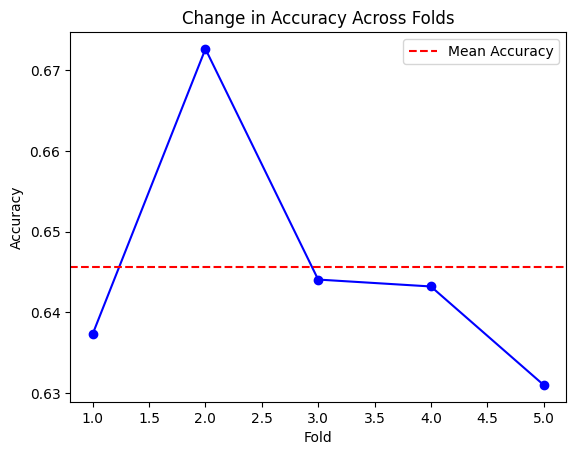

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import EarlyStopping


learning_rate = 0.001
# Define the number of folds
num_folds = 5

# Convert sentiments to numpy array
labels = np.array(data['Review_Sentiment'])

# Initialize the StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store results
accuracies = []
#optimizer = Adam(learning_rate=learning_rate)
# Iterate over folds
for fold, (train_index, val_index) in enumerate(skf.split(data['review_clean'], labels)):
    print(f"\nFold {fold + 1}/{num_folds}")
    train_data_fold, val_data_fold = data.iloc[train_index], data.iloc[val_index]

    # Tokenize and pad sequences for the current fold
    train_sequences_fold = tokenizer.texts_to_sequences(train_data_fold['review_clean'])
    val_sequences_fold = tokenizer.texts_to_sequences(val_data_fold['review_clean'])

    train_padded_fold = pad_sequences(train_sequences_fold, maxlen=max_len, padding='post', truncating='post')
    val_padded_fold = pad_sequences(val_sequences_fold, maxlen=max_len, padding='post', truncating='post')

    # Clone the model to reset weights for each fold
    model_fold = clone_model(model)

    # Compile the model
    model_fold.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    # Train the model on the current fold
    model_fold.fit(train_padded_fold, train_data_fold['Review_Sentiment'], epochs=50, validation_data=(val_padded_fold, val_data_fold['Review_Sentiment']),callbacks=[early_stopping])

    # Evaluate the model on the validation set for this fold
    _, accuracy = model_fold.evaluate(val_padded_fold, val_data_fold['Review_Sentiment'])
    accuracies.append(accuracy)

# Print the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print("\nMean Accuracy:", mean_accuracy)

# Plot the change in accuracies
plt.plot(range(1, num_folds + 1), accuracies, marker='o', linestyle='-', color='b')
plt.axhline(y=mean_accuracy, color='r', linestyle='--', label='Mean Accuracy')
plt.title('Change in Accuracy Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [21]:
test = pd.read_csv('/content/drive/MyDrive/NLP Project/UCIdrug_test.csv')
test['review_clean'] = review_clean(test['review'])
# Removing the stopwords
stop_words = set(stopwords.words('english'))
test['review_clean'] = test['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
test.loc[(test['rating'] >= 7), 'Review_Sentiment'] = 'Positive'
test.loc[test['rating'].isin([5, 6]), 'Review_Sentiment'] = 'Neutral'
test.loc[(test['rating'] <= 4), 'Review_Sentiment'] = 'Negative'
test['Review_Sentiment'] = test['Review_Sentiment'].map({'Positive': 1, 'Neutral': 2, 'Negative': 0})

In [22]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,Review_Sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,ive tried antidepressants years citalopram flu...,1
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,son crohns disease done well asacol complaints...,1
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,quick reduction symptoms,1
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,contrave combines drugs used alcohol smoking o...,1
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,birth control one cycle reading reviews type s...,1


In [23]:
test_sequences = tokenizer.texts_to_sequences(test['review_clean'])

In [24]:
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [25]:
predictions = np.argmax(model.predict(test_padded), axis=1)
accuracy = accuracy_score(test['Review_Sentiment'], predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(test['Review_Sentiment'], predictions))

1681/1681 [==============================] - 3s 2ms/step
Accuracy: 0.5708
              precision    recall  f1-score   support

           0       0.27      0.24      0.25     13497
           1       0.66      0.77      0.71     35440
           2       0.00      0.00      0.00      4829

    accuracy                           0.57     53766
   macro avg       0.31      0.34      0.32     53766
weighted avg       0.50      0.57      0.53     53766



In [26]:
test['Predicted_Sentiment'] = predictions
test['Predicted_Sentiment'] = test['Predicted_Sentiment'].map({0: 'Negative', 2: 'Neutral', 1: 'Positive'})

In [27]:
test[:10]

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,Review_Sentiment,Predicted_Sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,ive tried antidepressants years citalopram flu...,1,Positive
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,son crohns disease done well asacol complaints...,1,Negative
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,quick reduction symptoms,1,Positive
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,contrave combines drugs used alcohol smoking o...,1,Positive
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,birth control one cycle reading reviews type s...,1,Positive
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,3-Jul-14,13,4 days first 2 weeks using arms face put vasel...,0,Negative
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1,ive copper coil 3 months really excited though...,2,Positive
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,21-Apr-09,32,great ive 2 weeks last week 3 headaches went a...,1,Positive
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,18-Oct-16,21,ive methadone ten years currently trying get d...,1,Positive
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3,pill almost two years work far getting pregnan...,0,Positive


In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test['Review_Sentiment'], predictions)
precision = precision_score(test['Review_Sentiment'], predictions, average='macro')
recall = recall_score(test['Review_Sentiment'], predictions, average='macro')
f1 = f1_score(test['Review_Sentiment'], predictions, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

Accuracy: 0.5708
Precision: 0.3092
Recall: 0.3389
F1: 0.3225
